#  Quant Portfolio: Backtesting

By Joe Osborne: joe.osborne1337@gmail.com

Some of the techniques I use are from Hilpisch's Python for Finance: Mastering Data-Driven Finance 2nd Ed


Contents
#### Data retrival
#### Mean Reversion Strategy
##### For All Symbols
##### Optimize SMA1 and SMA2
#### Machine Learning Classification
##### Two Binary Features
##### Five Binary Features
##### Five Digitized Features
##### Sequential Test-Train Splits
##### Random Test-Train Splits 
#### Deep Neural Networks
##### DNN with Scikit-learn
##### DNN with TensorFlow

## Data retrival

First, we must import libraries...

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt

... and style our plots

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

Second, we must retrive the financial data. (From Hilpisch for now).

In [3]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [4]:
raw.info()

data = (pd.DataFrame(raw).dropna());
symbols = list(raw)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2216 entries, 2010-01-01 to 2018-06-29
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2138 non-null   float64
 1   MSFT.O  2138 non-null   float64
 2   INTC.O  2138 non-null   float64
 3   AMZN.O  2138 non-null   float64
 4   GS.N    2138 non-null   float64
 5   SPY     2138 non-null   float64
 6   .SPX    2138 non-null   float64
 7   .VIX    2138 non-null   float64
 8   EUR=    2216 non-null   float64
 9   XAU=    2211 non-null   float64
 10  GDX     2138 non-null   float64
 11  GLD     2138 non-null   float64
dtypes: float64(12)
memory usage: 225.1 KB


## Mean Reversion Strategy

This strategy uses a short term and long term moving average. The long term moving average lags the short term moving average. When they cross over, it indicates a change in trend.

When the short-term moving average rises through the long-term this indicates a bullish phase and when the short-term moving average slips below the long-term moving average this indicates a bearish phase.

This strategy ignores:
- Transactional costs
- Portfolio composition and optimization
    - Diversity
    - Risky and risk-less asset composition
    - Initial equity and leverage ratio

In [5]:
MAs = {'2mo': 42, '12mo': 252}; # in days
symbol = symbols[0]; 

for MA in MAs:
    data[symbol+'_MA_'+MA] = data[symbol].rolling(MAs[MA]).mean()        
data.dropna(inplace=True)

In [6]:
data.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD,AAPL.O_MA_2mo,AAPL.O_MA_12mo
Date,,,,,,,,,,,,,,
2010-12-31,46.079954,27.9100,21.03,180.00,168.16,125.75,1257.64,17.75,1.3377,1419.45,61.47,138.72,45.280967,37.120735
2011-01-03,47.081381,27.9800,20.85,184.22,173.05,127.05,1271.87,17.61,1.3351,1413.80,60.77,138.00,45.349708,37.186246
2011-01-04,47.327096,28.0875,21.15,185.01,173.08,126.98,1270.20,17.38,1.3301,1380.21,59.02,134.75,45.412599,37.252521
2011-01-05,47.714238,28.0000,20.94,187.42,174.00,127.64,1276.56,17.02,1.3151,1376.80,58.22,134.37,45.466102,37.322266
2011-01-06,47.675667,28.8200,20.77,185.86,172.21,127.39,1273.85,17.40,1.3001,1371.00,56.74,133.83,45.522565,37.392079


In [7]:
MA_symbols = [symbol,symbol+'_MA_'+'2mo',symbol+'_MA_12mo'];

#Buy when short term moving average is > long term, sell vice versa
data[symbol+'_Position'] = np.where(data[symbol+'_MA_'+'2mo'] > data[symbol+'_MA_'+'12mo'], 1, -1)

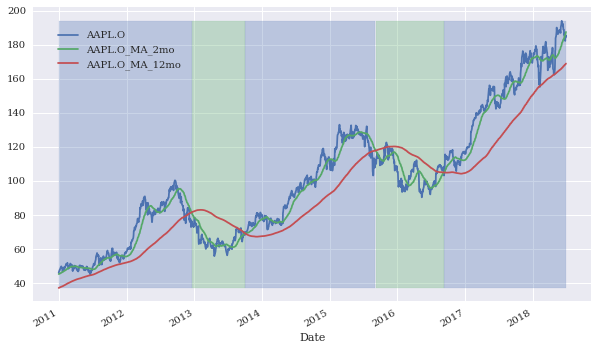

In [8]:
#Without position plotted
ax = data[MA_symbols].plot(figsize=(10, 6))

#With position plotted
#ax = data.plot( secondary_y=symbol+'_Position', figsize=(10, 6))

ax.get_legend().set_bbox_to_anchor((0.28, 0.95));

#Shade between moving averages
#ax.fill_between(data.index, data[symbol+'_MA_'+'2mo'].values, data[symbol+'_MA_'+'12mo'].values,\
#                 where=(data[symbol+'_MA_'+'2mo'].values > data[symbol+'_MA_'+'12mo'].values), color='C0', alpha=0.3)
#ax.fill_between(data.index, data[symbol+'_MA_'+'2mo'].values, data[symbol+'_MA_'+'12mo'].values,\
#                 where=(data[symbol+'_MA_'+'2mo'].values < data[symbol+'_MA_'+'12mo'].values), color='C1', alpha=0.3)

#Shade whole figure
min = data[MA_symbols].min().min()
max = data[MA_symbols].max().max()
ax.fill_between(data.index, min, max,where=(data[symbol+'_MA_'+'2mo'].values > data[symbol+'_MA_'+'12mo'].values),\
                color='C0', alpha=0.3)
ax.fill_between(data.index, min, max,where=(data[symbol+'_MA_'+'2mo'].values < data[symbol+'_MA_'+'12mo'].values),\
                color='C1', alpha=0.3)

In [9]:
data[symbol+'_Returns'] = np.log(data[symbol] / data[symbol].shift(1))  

In [10]:
data[symbol+'_Strategy'] = data[symbol+'_Position'].shift(1) * data[symbol+'_Returns']
data.dropna(inplace=True)

In [11]:
data.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD,AAPL.O_MA_2mo,AAPL.O_MA_12mo,AAPL.O_Position,AAPL.O_Returns,AAPL.O_Strategy
Date,,,,,,,,,,,,,,,,,
2011-01-03,47.081381,27.9800,20.85,184.22,173.05,127.05,1271.87,17.61,1.3351,1413.80,60.77,138.00,45.349708,37.186246,1,0.021500,0.021500
2011-01-04,47.327096,28.0875,21.15,185.01,173.08,126.98,1270.20,17.38,1.3301,1380.21,59.02,134.75,45.412599,37.252521,1,0.005205,0.005205
2011-01-05,47.714238,28.0000,20.94,187.42,174.00,127.64,1276.56,17.02,1.3151,1376.80,58.22,134.37,45.466102,37.322266,1,0.008147,0.008147
2011-01-06,47.675667,28.8200,20.77,185.86,172.21,127.39,1273.85,17.40,1.3001,1371.00,56.74,133.83,45.522565,37.392079,1,-0.000809,-0.000809
2011-01-07,48.017095,28.6000,20.66,185.49,170.69,127.14,1271.50,17.14,1.2916,1368.60,56.74,133.58,45.582089,37.462453,1,0.007136,0.007136


The performance of the moving average strategy for Apples stock is better than a long only strategy.

In [12]:
np.exp(data[[symbol+'_Returns',symbol+'_Strategy']].sum())  

AAPL.O_Returns     4.017148
AAPL.O_Strategy    5.811299
dtype: float64

#### For all symbols

In [13]:
MeanRevResults = pd.DataFrame()
for symbol in symbols:
    data = pd.DataFrame(raw[symbol])
    data.dropna(inplace=True)
    data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
    data['SMA1'] = data[symbol].rolling(MAs['2mo']).mean()
    data['SMA2'] = data[symbol].rolling(MAs['12mo']).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Returns']
    data.dropna(inplace=True)
    perf = np.exp(data[['Returns', 'Strategy']].sum())
    benchm = perf['Strategy'] - perf['Returns'];
    MeanRevResults = MeanRevResults.append(pd.DataFrame(
                {'Symbol':  symbol ,'SMA1': MAs['2mo'], 'SMA2': MAs['12mo'],
                 'MARKET': perf['Returns'],
                 'STRATEGY': perf['Strategy'],
                 'BENCHMARK': benchm},
                 index=[0]), ignore_index=True)  

In [14]:
MeanRevResults

,Symbol,SMA1,SMA2,MARKET,STRATEGY,BENCHMARK
0,AAPL.O,42,252,4.017148,5.811299,1.794151
1,MSFT.O,42,252,3.533142,0.787798,-2.745344
2,INTC.O,42,252,2.363766,0.549313,-1.814453
3,AMZN.O,42,252,9.443333,3.462586,-5.980747
4,GS.N,42,252,1.311667,1.200371,-0.111297
5,SPY,42,252,2.157296,1.296339,-0.860958
6,.SPX,42,252,2.161485,1.394976,-0.766509
7,.VIX,42,252,0.906479,0.000269,-0.906210
8,EUR=,42,252,0.890608,1.370496,0.479888
9,XAU=,42,252,0.904642,1.099720,0.195079


Very poor performance per unit per stock. Perhaps this can be improved through optimization

In [15]:
MeanRevResults['BENCHMARK'].sum()

-10.292299091699798

#### Optimize SMA1 and SMA2

In [16]:
from itertools import product

In [17]:
sma1 = range(20, 61, 4)  
sma2 = range(180, 281, 10) 

In [18]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):
    MeanRevResults = pd.DataFrame()
    for symbol in symbols:
        data = pd.DataFrame(raw[symbol])
        data.dropna(inplace=True)
        data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
        data['SMA1'] = data[symbol].rolling(SMA1).mean()
        data['SMA2'] = data[symbol].rolling(SMA2).mean()
        data.dropna(inplace=True)
        data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
        data['Strategy'] = data['Position'].shift(1) * data['Returns']
        data.dropna(inplace=True)
        perf = np.exp(data[['Returns', 'Strategy']].sum())
        benchm = perf['Strategy'] - perf['Returns'];
        MeanRevResults = MeanRevResults.append(pd.DataFrame(
                    {'Symbol':  symbol ,'SMA1': SMA1, 'SMA2': SMA2,
                     'MARKET': perf['Returns'],
                     'STRATEGY': perf['Strategy'],
                     'BENCHMARK': benchm},
                     index=[0]), ignore_index=True) 
    Sum_Bench = MeanRevResults['BENCHMARK'].sum()
    results = results.append(pd.DataFrame({'SMA1': SMA1, 'SMA2': SMA2,
                     'SUM_BENCHMARK': Sum_Bench},
                     index=[0]), ignore_index=True)

Even with (brute force, global) optimization, the best strategy looses money for all stocks when considering all stocks. 

In [19]:
results.sort_values('SUM_BENCHMARK', ascending=False).head(7)

,SMA1,SMA2,SUM_BENCHMARK
5,20,230,-8.070165
14,24,210,-8.394682
6,20,240,-9.160755
120,60,280,-9.214176
39,32,240,-9.348413
7,20,250,-9.404732
25,28,210,-9.471894


Instead of using one global moving average for all signals, one can optimize on a stock by stock basis. But one should be wary of overfitting. There will be no test train split used for this mean reversion data (however, I will incorporate this later as part of the ML methods.) 

In [20]:
results = pd.DataFrame()
for symbol in symbols:
    MeanRevResults = pd.DataFrame()
    for SMA1, SMA2 in product(sma1, sma2):
        data = pd.DataFrame(raw[symbol])
        data.dropna(inplace=True)
        data['Returns'] = np.log(data[symbol] / data[symbol].shift(1))
        data['SMA1'] = data[symbol].rolling(SMA1).mean()
        data['SMA2'] = data[symbol].rolling(SMA2).mean()
        data.dropna(inplace=True)
        data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
        data['Strategy'] = data['Position'].shift(1) * data['Returns']
        data.dropna(inplace=True)
        perf = np.exp(data[['Returns', 'Strategy']].sum())
        benchm = perf['Strategy'] - perf['Returns'];
        MeanRevResults = MeanRevResults.append(pd.DataFrame(
                    {'Symbol':  symbol ,'SMA1': SMA1, 'SMA2': SMA2,
                     'MARKET': perf['Returns'],
                     'STRATEGY': perf['Strategy'],
                     'BENCHMARK': benchm},
                     index=[0]), ignore_index=True)
    results = results.append(MeanRevResults.iloc[MeanRevResults['BENCHMARK'].idxmax()])
results.set_index('Symbol', inplace=True)

In [21]:
results

,BENCHMARK,MARKET,SMA1,SMA2,STRATEGY
Symbol,,,,,
AAPL.O,2.524831,4.650342,40.0,190.0,7.175173
MSFT.O,-2.183891,3.415656,28.0,270.0,1.231766
INTC.O,-1.127020,2.285517,60.0,270.0,1.158498
AMZN.O,-4.157877,9.690992,20.0,230.0,5.533115
GS.N,1.283537,1.344693,24.0,270.0,2.628230
SPY,-0.461018,2.154384,20.0,250.0,1.693366
.SPX,-0.453935,2.157813,24.0,250.0,1.703878
.VIX,-0.639088,0.683808,52.0,190.0,0.044720
EUR=,0.565743,0.883469,48.0,240.0,1.449212


Even if one were to use different moving averages for each stock, the returns are still unsatifactory compared to the benchmark.

In [22]:
results['BENCHMARK'].sum()

-2.4909558989512237

## Machine Learning Classification

Reset the data

In [26]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [27]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import warnings

In [28]:
warnings.simplefilter('ignore')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%matplotlib inline

In [29]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)
symbol = 'EUR='

data = pd.DataFrame(raw[symbol])

data['returns'] = np.log(data/ data.shift(1))

data.dropna(inplace=True)

If returns are > 0 then direction is 1 (or up). If returns are < 0 then direction is -1 (or down)

In [31]:
data['direction'] = np.sign(data['returns']).astype(int)

data.head()

,EUR=,returns,direction
Date,,,
2010-01-04,1.4411,0.006125,1
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1


In [32]:
lags = 2

In [38]:
def create_lags(data, lags, cols):
    '''
    Modifies data inplace to add lags of the return column
    
    Parameters
    ==========
    data: dataframe
        Contains Date (index), a single symbol, and the returns of that symbol
    lags: int
        Number of lags that the user desires
    cols: list of strings
        containing the symbols of previously added lags 
    MODIFIED FROM Hilspich to remove the use of global variables
    
    Results
    =======
    cols: list of strings
        as above
    '''
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)
    return cols

In [39]:
cols = []
cols = create_lags(data, lags, cols)

In [42]:
data.dropna(inplace=True)
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-06,1.4412,0.003058,1,-0.002988,0.006125
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544
2010-01-12,1.4494,-0.001310,-1,0.006984,0.006544


### Frequency Approach

Uses the 

In [57]:
def create_bins(data, cols, cols_bin, bins=[0]):
    '''
    Modifies data inplace to add bins of the lag column
    
    Parameters
    ==========
    data: dataframe
        Contains Date (index), a single symbol, and the returns of that symbol
    cols: list of strings
        containing the symbols of previously added lags 
    cols_bins: list of int
        containing the symbols of previously added lags and their bins 
    MODIFIED FROM Hilspich to remove the use of global variables
    
    Results
    =======
    cols: list of strings
        as above
    cols_bins: list of int
        containing the symbols of previously added lags and their bins 
    
    INPUT data and lags 
    
    '''
    
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)
        
    return cols, cols_bin

In [58]:
cols_bin = []
cols, cols_bin = create_bins(data, cols, cols_bin )

In [59]:
data[cols_bin + ['direction']].head()

,lag_1_bin,lag_2_bin,direction
Date,,,
2010-01-06,0,1,1
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1


Frequency of possible movements dependant on the features set

In [60]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()

lag_1_bin  lag_2_bin  direction
0          0          -1           237
                       0             4
                       1           276
           1          -1           280
                       0             1
                       1           295
1          0          -1           287
                       0             1
                       1           288
           1          -1           288
                       0             5
                       1           251
dtype: int64

In [61]:
res = grouped['direction'].size().unstack(fill_value=0) # puts frequencies as column

When lag_1_bin =1 and lag_2_bin = 1 (has had two periods of positive return), assume next period's direction is negative otherwise assume it will have positive return. This is just one condition based off the frequency data in ln 60. One must be careful as this technique is incredibly overfitted.

In [63]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) ==2, -1, 1) 

The strategy above is correct more often than not (ie true > false)

In [65]:
(data['direction'] == data['pos_freq']).value_counts()

True     1147
False    1066
dtype: int64

Now weights the correct guesses by the returns in these periods

In [74]:
data['strat_freq'] = data['pos_freq'] *data['returns']

The frequency strategy outperforms the long only strategy.

In [69]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.813126
strat_freq    1.016673
dtype: float64

<AxesSubplot:xlabel='Date'>

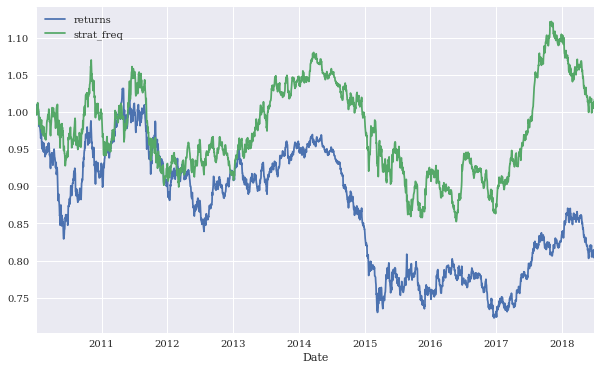

In [72]:
data[['returns','strat_freq']].cumsum().apply(np.exp).plot(figsize=(10,6))

### Two Binary Features

In [56]:
#TO ADD

[]

### Five Binary Features

In [ ]:
#TO ADD

### Five Digitized Features

In [ ]:
#TO ADD

### Sequential Test-Train Splits

In [ ]:
#TO ADD

### Random Test-Train Splits

In [ ]:
#TO ADD

### Deep Neural Networks

#### DNNs with scikit-learn

In [ ]:
#TO ADD

#### DNNs with TensorFlow

In [ ]:
#TO ADD